# Prepare data
---------------------
No to już wszystko mam zrobione więc łatwo

In [5]:
from signalutils.signalutils import readFiles, encodedLabels, calcMfccs, export_to_pickle, unpickle
import scipy

In [6]:
signals, labelEncoder = encodedLabels(readFiles(path="../samples"))

In [7]:
signals = calcMfccs(signals, window=scipy.signal.windows.boxcar, n_fft=512, hop_length=256, win_length=512, n_mfcc=13)

In [5]:
#wyrzuć ".wav" z nazwy
for signal in signals:
    signal['name'] = signal['name'].split('.')[0]

# Calc DTWs
---------------

Źródła: 
- https://www.youtube.com/watch?v=ERKDHZyZDwA&list=PLmZlBIcArwhMJoGk5zpiRlkaHUqy5dLzL&index=1
- https://www.researchgate.net/publication/260762671_Speech_recognition_using_MFCC_and_DTW
- https://stackoverflow.com/questions/48267199/comparing-mfcc-feature-vectors-with-dtw

Input: lista 112 nagrań zawierających informacje:

In [8]:
signals[0].keys()

dict_keys(['name', 'signal', 'sr', 'label', 'encodedLabel', 'mfccs', 'delta', 'delta2'])

## Approach 1 - DTW z macierzy MFCC

Jak liczymy MFCC z nagrania to zawsze dostajemy macierz o wymiarach (X,N) gdzie X - liczba okien, N - liczba współczynników. I trochę pojawia się problem, bo nie da się policzyć DTW z dwóch macierzy. Rozwiązaniem jest wykonanie innej operacji, która obliczy nam odległości pomiędzy pomiędzy wektorami (gdzie wektor to wartości współczynników w jednej chwili\oknie) i potem wynik tego obliczenia będzie już jedną macierzą, na której można od razu robić DTW.

Generalnie sprawa wygląda tak, że najpierw liczy się odległości pomiędzy wektorami z użyciem istniejących funkcji, czy to odległość euklidesowa, dot product czy inne takie i mamy już macierz na której możemy liczyć DTW.

Opcji do obliczania odległości mamy dużo https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

no generalnie prościej się nie dało, jest libka która robi dokładnie to:

https://github.com/pollen-robotics/dtw

In [11]:
from dtw import accelerated_dtw
import scipy
from tqdm.notebook import tqdm
import sys

In [ ]:
unpickle('data/AM1.pickle')

In [38]:
for entry_x in tqdm(signals):
    calculatedData=[]
    for entry_y in tqdm(signals):
        cost, cost_matrix, acc_cost_matrix, path = accelerated_dtw(entry_x['mfccs'].T, entry_y['mfccs'].T, scipy.spatial.distance.cosine)
        data = {
            "x": entry_x['name'],
            "y": entry_y['name'],
            "cost": cost,
            "cost_matrix": "cost_matrix",
            "acc_cost_matrix": acc_cost_matrix,
            "path":path
        }
        calculatedData.append(data)
    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

2


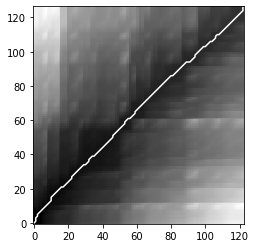

In [36]:
import matplotlib.pyplot as plt
plt.imshow(calculatedData[1]['value'][2].T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(calculatedData[1]['value'][3][0],calculatedData[1]['value'][3][1], 'w')
plt.show()

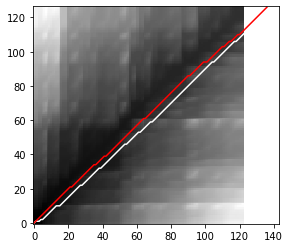

In [32]:
import matplotlib.pyplot as plt
plt.imshow(calculatedData[1]['value'][2].T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(calculatedData[1]['value'][3][0],'w')
plt.plot(calculatedData[1]['value'][3][1],'r')
plt.show()

In [ ]:
for entry_x in tqdm(signals):
    for entry_y in tqdm(signals):
        data = {
            "x": entry_x['name'],
            "y": entry_y['name'],
            "value": accelerated_dtw(entry_x['mfccs'].T, entry_y['mfccs'].T, scipy.spatial.distance.cosine)
        }
        calculatedData.append(data)

In [155]:
!ls

calcdtw.py  signalutils  test.pickle  Untitled.ipynb


In [161]:
data = unpickle('test.pickle')

UnpicklingError: pickle data was truncated

In [177]:
data['value']

(5.615706137577116,
 array([[0.00291379, 0.00104734, 0.00227926, ..., 0.00785538, 0.02826402,
         0.02120502],
        [0.0016875 , 0.00088117, 0.00125075, ..., 0.00913643, 0.03393736,
         0.02340392],
        [0.00611327, 0.00310601, 0.00530015, ..., 0.00884869, 0.02859153,
         0.02135541],
        ...,
        [0.00703451, 0.00481343, 0.00612349, ..., 0.00735805, 0.02778952,
         0.01884281],
        [0.0071785 , 0.0049113 , 0.00596807, ..., 0.00598864, 0.02476755,
         0.01557615],
        [0.00315308, 0.00325603, 0.00211299, ..., 0.00724682, 0.03154012,
         0.01788256]]),
 array([[2.91379122e-03, 3.96113582e-03, 6.24039107e-03, ...,
         1.03385241e+01, 1.03667881e+01, 1.03879931e+01],
        [4.60129138e-03, 3.79496295e-03, 5.04571111e-03, ...,
         1.00678248e+01, 1.01017622e+01, 1.01251661e+01],
        [1.07145644e-02, 6.90097361e-03, 9.09511358e-03, ...,
         1.00061087e+01, 1.00347003e+01, 1.00560557e+01],
        ...,
        [1.04508

# Approach 2 - Uśrednienie MFCC

Pomysł z drugim podejściem jest podobny do zadania pierwszego, gdzie liczymy jedno MFCC z całej wypowiedzi:
1. Policz mfcc z okienkami
2. Oblicz średnie wartości MFCC ze wszystkich okien
3. Oblicz DTW na tych średnich MFCC